How does sociability affect a person's mobility variety?

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import geopy.distance
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
checkin_index = ['UserID', 'VenueID', 'time', 'time_offset']
checkins = pd.read_csv("data/checkins_anonymized.txt", sep='\t', names = checkin_index)

In [3]:
friendship_index = ['UserID1', 'UserID2']
friendship_old = pd.read_csv("data/friendship_old.txt", sep='\t', names = friendship_index)
friendship_new = pd.read_csv("data/friendship_new.txt", sep='\t', names = friendship_index)

In [4]:
POI_index = ['VenueID', 'latitude', 'longitude', 'category', 'country'] #total 519 categories
POI = pd.read_csv("data/raw_POIs.txt", sep='\t', names = POI_index)

In [5]:
# Second: influence of sociability, e.g. compute the cosine similarity between users who have less/more friends

In [6]:
# Compute number of friends for each user based on friendship_new

user_sociability =  pd.concat([friendship_new['UserID1'],friendship_new['UserID2']], axis=0)
user_sociability = user_sociability.value_counts()
user_sociability.name = 'sociability'
user_sociability = user_sociability.reset_index()

In [90]:
bins = np.logspace(0, 2.75, 8)
bin_centers = 0.5*(bins[1:] + bins[:-1])

user_sociability_c = user_sociability.sample(len(user_sociability)//10)
user_sociability_c.reset_index(drop=True)

bin_data = []
for i in range(len(bin_centers)):
    index = (user_sociability_c['sociability'] >= bins[i]) & (user_sociability_c['sociability'] < bins[i+1])
    current_users = user_sociability_c[index]
    bin_data.append(current_users)

In [91]:
# Replace each user with their visit vector

venue_category = POI[['VenueID', 'category']]
user_checkin = checkins[['UserID', 'VenueID']]
user_category = user_checkin.merge(venue_category, left_on='VenueID', right_on='VenueID')
user_category = user_category[['UserID', 'category']]

categories = user_category['category'].unique()

In [92]:
def user_to_locvector(x):
    location_vector = [0]*len(categories)
    user_categories = user_category[user_category['UserID'] == x]
    for category in user_categories['category']:
        location_vector[categories_idx[category]] += 1
    return location_vector

categories_idx = dict(zip(categories, range(len(categories))))

bin_data_vectors = [list(data['index']) for data in bin_data]

for i in range(len(bin_data_vectors)):
    for j in range(len(bin_data_vectors[i])):
        bin_data_vectors[i][j] = user_to_locvector(bin_data_vectors[i][j])

In [93]:
# Compute cosine similarity within each bin
similarities = [cosine_similarity(bin).mean() for bin in bin_data_vectors]

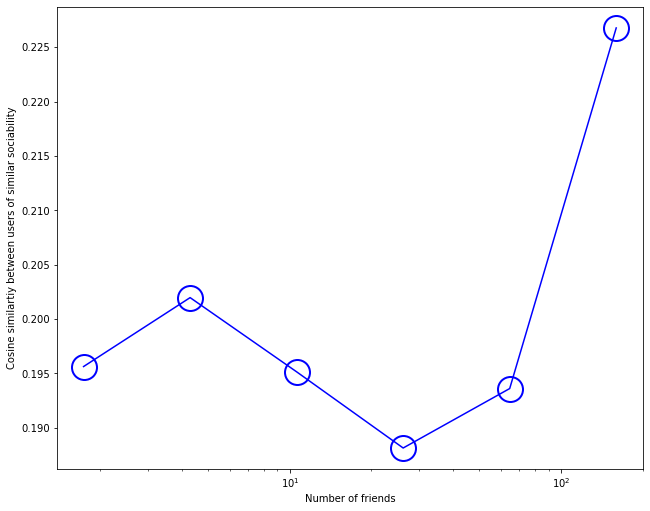

In [100]:
fig = plt.figure(figsize=(10.5, 8.5))
ax = fig.add_subplot(111)

# The last category usually only contain outliers (even with a log scale they are still outliers, so better remove them)
plt.plot(bin_centers[:-1], similarities[:-1], 'b', markersize=25, marker='o', markeredgewidth=2, fillstyle='none')

ax.set_xscale('log')

plt.ylabel("Cosine similartiy between users of similar sociability")
plt.xlabel("Number of friends")


plt.show()

From the plot's we can conclude that the more friends a person has, the (very slightly) less "unique" she is, in the sense that their cosine similarity with people who have approximatly as much is higher the more a person has friends.

Note however the difference is not too large (in this case similarty goes from 0.19 to 0.23) so the effect of sociability is not actually a big factor is how unique a person's mouvements are. However, after running the code re-sampling quite a few time we however do observe the same pattern every time: a somewhat constant value for consine similarity followed by a large increase above 100 friends, so there is a pattern.

An explanation that comes to mind is that there are less users with a very high number of friends, so it could be expected that the "variance" in this group will less likely be large (it is less likely to find many "unique" users if the group of users is smaller).

This could also be explained by the fact that the more a person has friends, the most likely they will get influenced by their friends, so their mouvements are usually less unique (and might follow trends).

From this observation we could conclde that there is a correlation between a person's sociability and the uniqueness of their movement, but that influence is not a major factor.